---
# 삼성 INTENSIVE 현업 PROJECT
---

## **`코드 run 속도가 매우 느립니다.`**
## **`다 읽어서 평가한 후, Run All 버튼 추천드립니다.`**

---
## 데이터 생성

![플라즈마 이미지](image/project/plasma.jpg)

> ### 배경

- 플라즈마 사용 공정 설비에서 문제 발생 시, 플라즈마 광 신호 세기가 불안정해집니다.

- 제가 하는 업무는 이러한 플라즈마 이상 신호를 진단하기 위해, 플라즈마 광 신호를 실시간 측정하는 센서를 개발하고 있습니다.

  ※ 플라즈마에서 방출된 photon을 electron으로 변환하여, PMT 소자를 이용해 플라즈마 광 신호 세기를 측정하는 원리입니다.

> ### 요구사항

- 플라즈마 광 신호 데이터 양이 너무 많아 분석하는데 시간이 오래 걸립니다. (50,000 points/s)

  1. **Streaming Data**: 초당 10,000,000 포인트를 생성합니다.

  2. **Trend Data**: 초당 200 포인트를 생성하며, Streaming Data에서 최소값, 최대값, 평균을 50,000 포인트마다 샘플링하여 생성합니다.

- 플라즈마 이상 신호를 자동으로 진단하는 모델을 개발해서 이상 신호를 조기에 감지하는 것을 목표로 합니다.

- 최종적으로 엔지니어에게 알람을 제공하는 시스템 구축해, 플라즈마 공정 설비 안정성을 유지하는 것을 목표로 합니다.

---
### 만드려는 센서 신호 데이터 정의

센서 데이터는 회사 보안으로 인한 반출 문제로 센서 데이터를 생성해야 합니다.

만드려는 센서 신호의 세기는 0 ~ 5 값이며, 값은 소수점 형태로 (10 points/s) 최대한 실제 데이터와 비슷하게 만들었습니다.

총 7개 이며 신호는 아래와 같습니다

※ 데이터 위치 : ./data/raw/ → csv 파일

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_4](image/base_signal/signal_4.png)
![signal_5](image/base_signal/signal_5.png)
![signal_6](image/base_signal/signal_6.png)
![signal_7](image/base_signal/signal_7.png)

### 정상 신호의 정의

정상 신호는 다음과 같이 정의됩니다:

- **Stable한 신호**: 단계가 변경될 때를 제외하고 안정적으로 유지되는 신호입니다.

![normal](image/project/normal.png)

### 이상 신호의 정의
이상 신호는 다음과 같이 정의됩니다:

1. **Outlier 발생 지점**: 안정적인 신호에서 벗어나 이상 현상이 발생한 지점입니다.

![outlier](image/project/outlier.png)

2. **Variation이 커지는 영역**: 안정적인 신호에서 변동이 크게 나타나는 지점입니다.

![noise](image/project/noise.png)

### 특이 사항

![신호 step](image/project/signal_step.png)

위 그림과 같이 step(구간) 별로 step 시작 부분에 신호 변곡점이 생기는데 해당 부분은 이상 신호로 진단하지 말아야 합니다.

전처리로 해당 특이 사항을 제거했다는 가정하에, stable한 구간에서 이상 신호를 만들려고 합니다.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### 함수 설명

- **add_outlier_signal**: 특정 구간에 이상치(outlier)를 생성하는 함수 (n개의 이상치를 추가)
- **add_noise_signal**: 정규 분포 노이즈를 생성하여 신호에 추가하는 함수 (특정 범위 내에서)

### 정상/비정상 신호 생성

기본 신호(Base Signal)를 기반으로 다음 두 가지 함수를 사용하여 정상 및 비정상 신호를 생성합니다:

1. **정상 신호 (Normal Signal)**
   - 기본 신호에 `add_noise_signal` 함수를 적용하여 생성합니다.
   - 전체 신호에 0.01%의 랜덤 노이즈를 추가합니다. (SNR=1000, Signal 1000 : Noise 1)

2. **이상치 신호 (Outlier Signal)**
   - 기본 신호에 0.01%의 랜덤 노이즈를 추가한 후, `add_outlier_signal` 함수를 적용하여 생성합니다.
   - 특정 구간에 이상치를 추가합니다.

3. **노이즈 신호 (Noise Signal)**
   - 기본 신호에 0.01%의 랜덤 노이즈를 추가한 후, `add_noise_signal` 함수를 적용하여 생성합니다.
   - 특정 구간에 정규 분포 노이즈를 추가합니다.

In [2]:
SNR = 1000

In [3]:
def generate_data(signal_func, num_samples, *args):
    data_list = []
    for _ in range(num_samples):
        val = signal_func(*args)
        data_list.append(val)
    res = np.vstack(data_list)
    return np.round(res, 6)

def make_signal_with_noise(signal):
    signal_with_noise = np.copy(signal)
    signal_with_noise += np.random.normal(scale=1/SNR, size=len(signal))
    return signal_with_noise

def add_outlier_signal(signal, outlier_ratio, range_, n_outlier=1):
    start, end = range_
    modified_signal = make_signal_with_noise(signal)
    outlier_index_list = np.random.choice(range(start, end+1), size=n_outlier, replace=False)
    for outlier_index in outlier_index_list:
        modified_signal[outlier_index] *= outlier_ratio
    return modified_signal

def add_noise_signal(signal, noise_ratio, range_):
    start, end = range_
    noisy_signal = make_signal_with_noise(signal)
    noisy_signal[start:end+1] += np.random.normal(scale=np.mean(signal)*noise_ratio, size=end-start+1)
    return noisy_signal

In [4]:
def get_original_signal():
    return {i: np.loadtxt(f'./data/raw/trend_data{i}.csv', delimiter=',') for i in range(1, 8)}

In [5]:
signal_dict = get_original_signal()

위의 기본 신호 7개 중, 다양한 신호 패턴을 다룰 수 있게 4개의 기본 신호를 선정했습니다.

![signal_1](image/base_signal/signal_1.png)
![signal_2](image/base_signal/signal_2.png)
![signal_3](image/base_signal/signal_3.png)
![signal_5](image/base_signal/signal_5.png)

또한 기본 신호마다 outlier, noise 추가할 구간을 나눠주었습니다.

In [6]:
base_signal_idx = [1, 2, 3, 5]
base_signal_dict = {key: signal_dict[key] for key in base_signal_idx}
base_signal_section = {
    1: [(200, 400), (500, 700), (850, 940)],
    2: [(200, 800), (900, 950), (1030, 1080)],
    3: [(200, 500), (600, 750), (800, 900)],
    5: [(50, 200), (400, 1200), (1450, 1510)]
}

만든 함수를 이용해 신호를 생성

random으로 생성 신호를 추출하여 그래프를 그려 유효한지 확인

In [7]:
signal_idx = 1
section_idx = 0

n_normal_samples = 10000

outlier_ratio = 1.4
n_outlier = 1
n_outlier_samples = 1000

noise_ratio = 0.05
n_noise_samples = 1000

section = base_signal_section[signal_idx][section_idx]
signal = base_signal_dict[signal_idx]

normal_signal = generate_data(add_noise_signal, n_normal_samples, signal, 1/SNR, [0, len(signal)-1])
outlier_signal_array = generate_data(add_outlier_signal, n_outlier_samples, signal, outlier_ratio, section, n_outlier)
noise_signal_array = generate_data(add_noise_signal, n_noise_samples, signal, noise_ratio, section)

In [8]:
def check_signal_validity(signal, n_samples, n_cols=2):
    indices = np.random.choice(len(signal), n_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_samples//n_cols+1, n_cols, i+1)
        plt.plot(signal[idx])
        plt.title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()

normal signal (10000, 972)


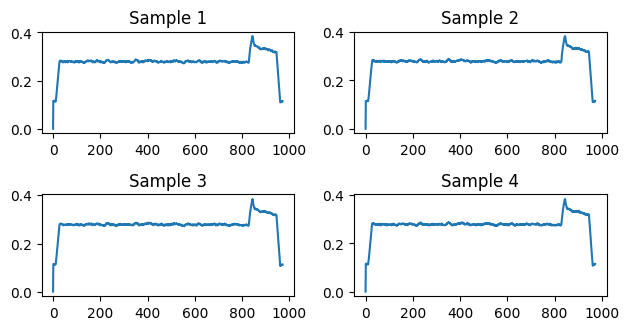

outlier signal (1000, 972)


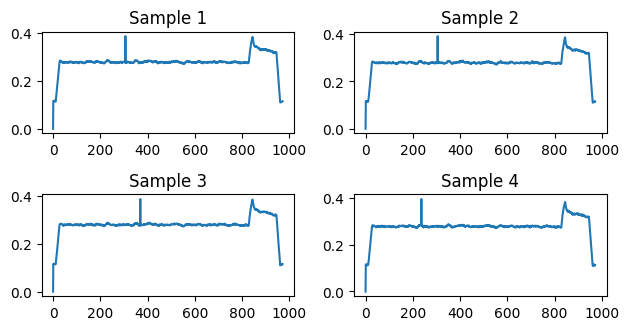

noise signal (1000, 972)


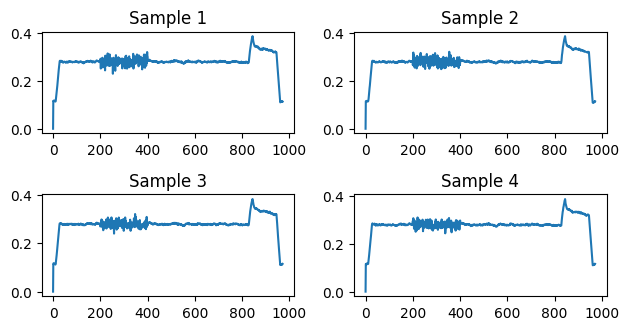

In [9]:
n_samples = 4
print('normal signal', normal_signal.shape)
check_signal_validity(normal_signal, n_samples)
print('outlier signal', outlier_signal_array.shape)
check_signal_validity(outlier_signal_array, n_samples)
print('noise signal', noise_signal_array.shape)
check_signal_validity(noise_signal_array, n_samples)

### 정상/비정상 신호 생성 기준

기본 신호 4개 기준, section은 3개로 전부 동일 (즉, 신호 1개당 3개 구간)

1. **정상 신호 (Normal Signal)**
   - 개수: 10,000 개

2. **이상치 신호 (Outlier Signal)**
   - 개수: 1,800 개 (구간 별 600 개)
   - 크기: 기존 신호의 1.4배
   - 개수: 1 point

3. **노이즈 신호 (Noise Signal)**
   - 개수: 1,800 개 (구간 별 600 개)
   - 크기: 기존 신호 + 신호 평균 * 0.05 scale을 갖는 정규분포

### Target columns 설명
1. **Target**
   - 0: 정상 신호
   - 1: 이상치 신호 (구간 1)
   - 2: 노이즈 신호 (구간 1)
   - 3: 이상치 신호 (구간 2)
   - 4: 노이즈 신호 (구간 2)
   - 5: 이상치 신호 (구간 3)
   - 6: 노이즈 신호 (구간 3)

2. **Section**
   - 구간 (순서대로 1, 2, 3)
   - signal 1: [(200, 400), (500, 700), (850, 940)]
   - signal 2: [(200, 800), (900, 950), (1030, 1080)]
   - signal 3: [(200, 500), (600, 750), (800, 900)]
   - signal 5: [(50, 200), (400, 1200), (1450, 1510)]

In [10]:
# data 만드는 기준 정보
n_normal_samples = 10000

outlier_ratio = 1.4
n_outlier = 1
n_outlier_samples = 600

noise_ratio = 0.05
n_noise_samples = 600

target_normal = 0

In [11]:
total_dict = {}
for signal_idx, signal in base_signal_dict.items():
    normal_signal = generate_data(add_noise_signal, n_normal_samples, signal, 1/SNR, [0, len(signal)-1])
    row_data = np.copy(normal_signal)
    
    for section in base_signal_section[signal_idx]:
        signal = signal_dict[signal_idx]

        outlier_signal_array = generate_data(add_outlier_signal, n_outlier_samples, signal, outlier_ratio, section, n_outlier)
        noise_signal_array = generate_data(add_noise_signal, n_noise_samples, signal, noise_ratio, section)
        
        row_data = np.vstack((row_data, outlier_signal_array, noise_signal_array))
    
    s = 0
    e = n_normal_samples

    df = pd.DataFrame(row_data)    
    df.loc[s:e, 'target'] = target_normal
    for i, v in enumerate(base_signal_section):
        s = e
        e = s+n_outlier_samples
        df.loc[s:e, 'target'] = i+1
        
        s = e
        e = s+n_noise_samples
        df.loc[s:e, 'target'] = i+4
        
    df['target'] = df['target'].astype(int)
    
    total_dict[signal_idx] = df

value_counts, bar plot, pie plot 이용, 개수 확인 결과 완료 (아래 코드 및 사진)

정상 신호: 10,000 개, 이상치 신호: 1,800 개 (구간 별 600 개), 노이즈 신호: 1,800 개 (구간 별 600 개)

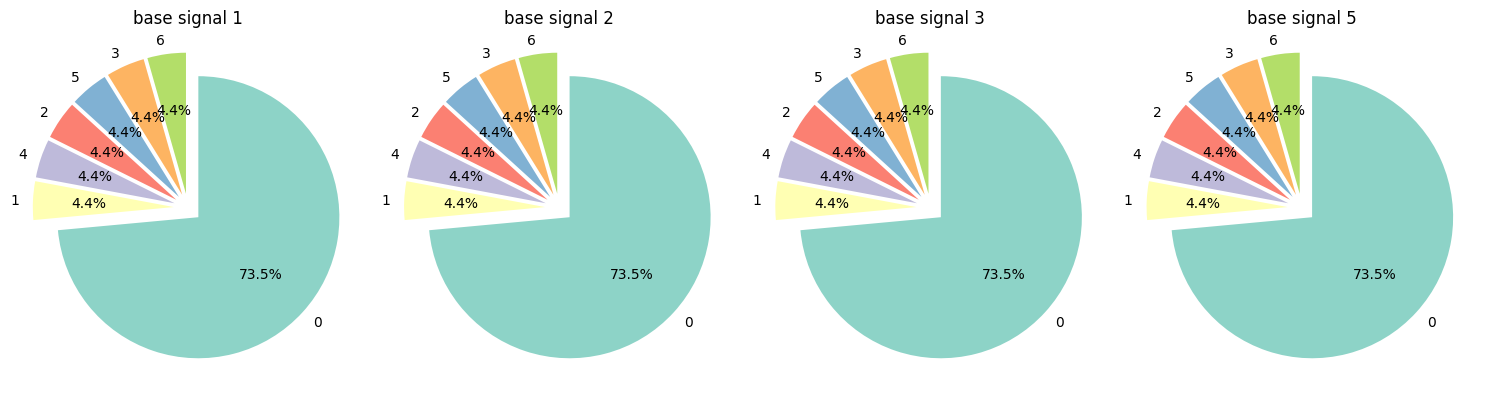

In [12]:
plt.figure(figsize=(15, 5))
for i, (key, value) in enumerate(total_dict.items(), start=1):
    plt.subplot(1, len(total_dict), i)
    
    counts = total_dict[key]['target'].value_counts()
    explode = [0.1] * len(counts)
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, counterclock=False, explode=explode, colors=cm.Set3.colors)
    plt.title(f'base signal {key}')
plt.tight_layout()
plt.show()

구간 별로 제대로 신호가 제대로 만들어졌는지 np.random.choice를 이용, 무작위로 뽑아 확인 결과 잘 만들어짐

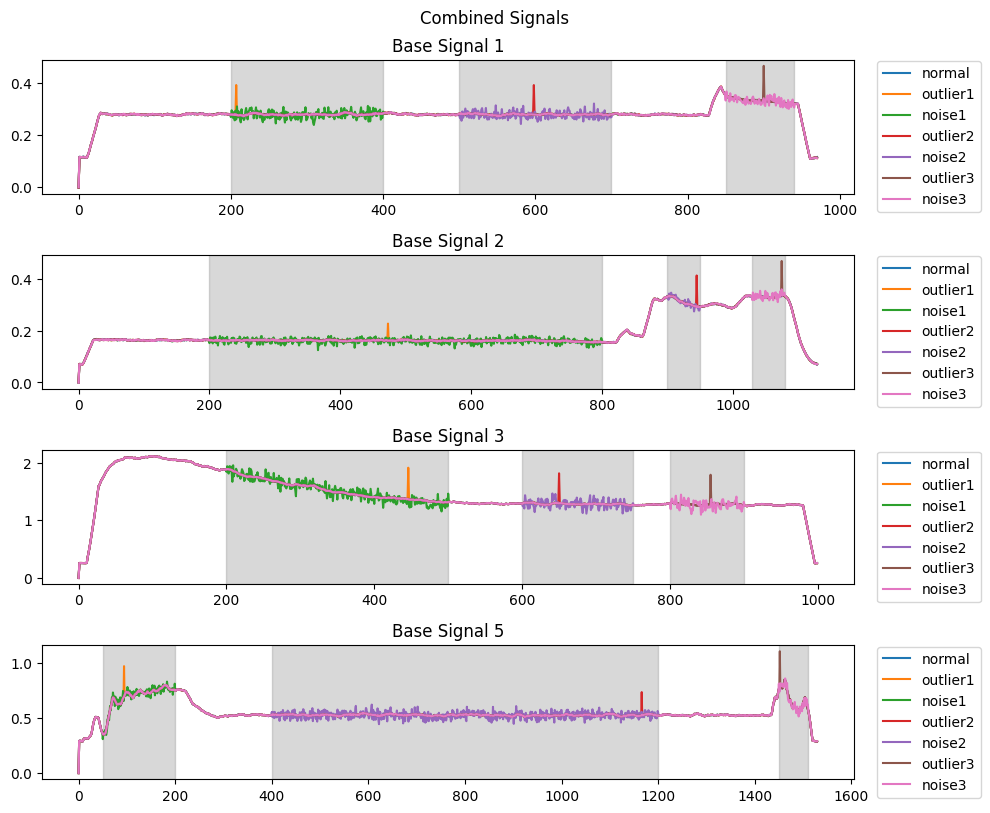

In [13]:
def generate_indices(start, end):
    return np.random.choice(range(start, end))

plt.figure(figsize=(10, 10))
plt.suptitle('Combined Signals')
for i, signal_idx in enumerate(base_signal_idx, start=1):
    signal_data = total_dict[signal_idx].iloc[:,:-2]
    normal = signal_data.iloc[generate_indices(0, 10000)]
    outlier1 = signal_data.iloc[generate_indices(10000, 10600)]
    noise1 = signal_data.iloc[generate_indices(10600, 11200)]
    outlier2 = signal_data.iloc[generate_indices(11200, 11800)]
    noise2 = signal_data.iloc[generate_indices(11800, 12400)]
    outlier3 = signal_data.iloc[generate_indices(12400, 13000)]
    noise3 = signal_data.iloc[generate_indices(13000, 13600)]

    plt.subplot(5, 1, i)
    plt.title(f'Base Signal {signal_idx}')
    plt.plot(normal, label='normal')
    plt.plot(outlier1, label='outlier1')
    plt.plot(noise1, label='noise1')
    plt.plot(outlier2, label='outlier2')
    plt.plot(noise2, label='noise2')
    plt.plot(outlier3, label='outlier3')
    plt.plot(noise3, label='noise3')
    for idx in base_signal_section[signal_idx]:
        plt.axvspan(xmin=idx[0], xmax=idx[1], color='gray', alpha=0.3)
    
    plt.legend(bbox_to_anchor=(1.02, 1.04), loc='upper left')
plt.tight_layout()
plt.show()

만든 데이터를 pickle 형태로 저장

※ csv로 저장했는데 파일 당 100MB가 넘어, 계속 다운되는 현상 발생(찾아보니 pickle 파일이 리소스 덜 먹는다함)

![pickle vs csv 이미지](image/project/pickle_vs_csv.png)

[출처](https://allsound.tistory.com/162)

In [14]:
for key, value in total_dict.items():
    if not os.path.exists('./data/signal'):
        os.makedirs('./data/signal')
    filename = f"./data/signal/data_{key}.pkl"
    value.to_pickle(filename)

## 데이터 생성 완료

---

---
# 삼성 INTENSIVE 현업 PROJECT
---

---
## **기획**


### [배경 설명 & 요구사항 확인]

![플라즈마 이미지](image/project/plasma.jpg)

> ### 배경
- 플라즈마 사용 공정 설비에서 문제 발생할 경우, 플라즈마 광 신호 세기가 불안정해집니다.
- 제가 하는 업무는 이러한 플라즈마 이상 신호를 진단하기 위해, 플라즈마 광 신호를 실시간 측정하는 센서를 개발하고 있습니다.

  ※ 플라즈마에서 방출된 photon을 electron으로 변환하여, PMT 소자를 이용해 플라즈마 광 신호 세기를 측정하는 원리입니다.

> ### 요구사항
- 플라즈마 광 신호 데이터 양이 너무 많아 분석하는데 시간이 오래 걸립니다. (50,000 points/s)
- 플라즈마 이상 신호를 자동으로 진단하는 모델을 개발해서 이상 신호를 조기에 감지하는 것을 목표로 합니다.
- target 이상 신호는 1 point 튀는 outlier 신호와 불안정하게 진동하는 수십 points 신호입니다.
- 현재 과정에서의 목표는 설비 별로 발생하는 이상 신호를 진단하는 개별 모델을 만드는 것입니다.
- 최종적으로 엔지니어에게 알람을 제공하는 시스템 구축해, 플라즈마 공정 설비 안정성을 유지하는 것을 목표로 합니다.

### [문제 범위 설정]

- 주요 목표는 플라즈마 광 신호를 실시간 측정하는 센서로부터 생성된 데이터를 사용하여 이상 신호 진단하는 모델을 개발하는 것입니다.

### [문제 정의 도출]

- 센서 데이터 기반으로 이상 신호를 자동으로 진단하는 자동 이상 진단 모델을 개발합니다.
  1. 플라즈마 광 신호의 정상 범위 정의
  2. 정상 범위를 벗어나는 이상 신호 정의
  3. 정상 신호와 이상 신호 식별하는 모델 개발
  4. 개발 모델 검증, 성능 평가 지표 설정
  5. 테스트 후 모델 조정 및 개선

### [데이터 확보 방법]

- 사내 공정 설비에 장착된 센서에 접근해서 신호 데이터를 추출합니다.

   - 센서 데이터 사외 반출이 안 되어 직접 제작했습니다.
   - 실제 신호 데이터와 최대한 유사하게 base signal을 만들고 noise와 이상 신호를 추가하여 직접 만들었습니다.
   
      ※ 실제 현업에서 사용하는 데이터의 양이 너무 많아 도저히 만들 수 없어 최대한 많은 포인트로 제작했습니다. (avg 1,000 points/signal)

### [활용 데이터 정의]

- 데이터 소스: 플라즈마 광 센서 데이터
- 데이터 유형:
   1. 정형 데이터이며, 2차원 배열 형식의 숫자 데이터
- Feature:
   1. Feature는 센서 데이터의 인덱스 (시간 순, 마지막 column 전까지)
   2. 마지막 column은 target column
   3. target column의 값은 0(정상), 1, 2, 3, 4, 5, 6 (이상치/흔들림, 구간별)
- 형태:
   1. pickle 파일
   2. 총 4가지의 다른 유형의 신호 데이터를 가짐
   3. 각 파일은 13,600 건의 레코드를 포함
   4. column 개수는 신호 길이에 따라 다름

### [분석시 예상되는 어려움]

- 고차원 데이터: 데이터 양이 많아 리소스가 많이 투입되고 전처리 하기 어려움 (1 파일의 shape: 13,600 x 1,000, 4개의 파일)

- 이상치 데이터 불균형: 정상 신호 1,000 개 중 이상치 1개 (0.1% 이하)

- 클래스 불균형: 정상 신호와 이상 신호간 비율이 불균형 (10,000 vs 3,600)

- 센서 노이즈 및 오차: 빛의 신호가 약해질 수록 상대적으로 노이즈가 커져 모델 성능 저하 가능성 존재

- 모델 설명 가능성: 상사를 설득해야 하는 업무 특성 상, 딥러닝 같이 설명 불가능한 모델은 사용이 어려움

### [문제 해결을 위한 모델 사용 방법]

- 데이터 전처리
   - 결측치가 존재하는 경우 해당 행은 제거
   - 모두 동일한 값을 가지는 column 제거 (특정 feature가 모든 샘플에 같은 상수 값을 가짐)
   - column끼리 비교하여 같은 값을 가지는 column들이 있다면 제거

- 데이터 시각화
   - 데이터 구조를 파악하여 특징 확인 (head, columns, unique, describe, info)
   - 이상치나 노이즈를 확인하기 위해 데이터 분포 시각화 및 기초 통계량 확인
   - target 값 별로 어떤 종류의 이상 신호인지 확인
   - 각 특성 분포를 시각화하여 데이터 특성 파악
   - 정상 신호와 이상 신호 간의 클래스 비율 확인하여 불균형 있는지 확인
   - 신호 한 개의 데이터에서 이상 신호 데이터 비율 확인 (비정상/정상)

- 모델 선택과 학습
   1. Feature Scaling
      - Standardization
   2. 모델 선택
      - 설명 불가능한 딥러닝 모델 보다는 설명할 수 있는 머신러닝 모델을 우선 고려
      - target 데이터가 있기 때문에 분류해주는 머신러닝 지도학습 모델 평가 (강사님이 다 돌려보래서 배운 분류 모델 전부 돌릴 예정)
         1. KNN
         2. Logistic Regression
         3. Naive Bayes
         4. Decision Tree
         5. Support Vector Machine
         6. Random Forest
         7. AdaBoost
         8. GradientBoosting
         9. LDA
      - 위에서 나온 결과를 토대로 모델을 조합하는 앙상블 모델도 평가
         1. Voting
         2. Bagging
         3. Stacking
   3. 모델 학습
      - 데이터를 학습, 테스트 셋으로 나누어서 학습
      - hpyer parameter tuning이 필요한 경우, StratifiedKFold와 GridSearchCV를 이용해서 tuning
      - 파일 용량이 커, 학습 시간이 오래 걸리면 PCA나 LDA를 이용해 차원 축소 후 모델 적용

- 모델 평가
   - 모델의 성능을 평가하기 위해 accuracy, prcision, recall, f1 score
   - classfication, confusion matrix 등을 사용

- 모델 최적화와 향상
   - Cross validation을 이용하여 모델 평가
   - GridSearchCV를 이용하여 모델 별 하이퍼 파라미터 튜닝을 통한 모델 성능 최적화
   - 50% 이상의 성능을 내는 모델들을 조합하여 앙상블 기법 사용해서 최적화 모델 생성

---
### **내용이 너무 길어지는 관계로 총 4개의 파일 중 첫 번째 파일에 대한 전체 과정을 진행한 후**

### **결과가 좋은 모델 순으로 나머지 세 개 파일에 대해 진행하겠습니다.**

### **`모델 학습 속도가 매우 느리다면 ./image/model_result에 나와있는 그림파일 참고하세요 `**

---
## **준비**

### [데이터 수집 및 로드]

- 사내 공정 설비에 장착된 센서에 접근해서 신호 데이터를 추출합니다.
- 데이터는 tdms 형식으로 저장되며, python tdms 라이브러리를 사용해서 로드합니다.

   ※ tdms는 National Instrumnet 독자 포맷으로 적용이 어려워, 여기서는 편의상 빠른 속도의 pickle을 사용하겠습니다.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df = pd.read_pickle('./data/signal/data_1.pkl')

### [데이터 전처리]

---
결측치 확인 및 확인 시, 해당 row 제거

In [17]:
def report_null_rows(df):
    null_rows = df.isnull().sum(axis=1)
    rows_with_null = null_rows[null_rows != 0].index.tolist()
    print('제거할 행:', rows_with_null)
    return df.drop(index=rows_with_null)

df = report_null_rows(df)

제거할 행: []


---
모두 같은 상수 값을 가지는 column 제거

In [18]:
def remove_uniform_columns(df):
    columns_to_remove = [col for col in df.columns if df[col].nunique() == 1]
    print('제거된 열:', columns_to_remove)
    return df.drop(columns=columns_to_remove)

df = remove_uniform_columns(df)

제거된 열: []


---
column끼리 비교하여 같은 값을 가지는 column들이 있다면 제거

In [19]:
def check_duplicate_columns(df):
    df_T = df.T.drop_duplicates().T
    columns_to_remove = df.columns.difference(df_T.columns)
    df_T['target'] = df_T['target'].astype(int)
    print('제거된 열:', columns_to_remove.tolist())
    return df_T

df = check_duplicate_columns(df)

제거된 열: []


데이터 전처리 과정을 통해 아래 내용을 파악했습니다.
- isnull().sum() 이용, 해당 데이터에 결측치가 없음을 확인했습니다.
- nunique()==1 이용, 값이 전부 동일한 상수인 column이 없음을 확인했습니다. (target과 관련 없는 무의미한 feature)
- drop_duplicates() 이용, 같은 값을 가지는 column이 없습니다. (중복되어 선형 족속인 feature)

<br>

가이드에는 데이터 전처리 시, 데이터 스케일링 하라고 적혀져 있지만,

**저는 데이터 스케일링은 EDA를 통해 데이터 특성 파악 및 분석 후, 진행하겠습니다.**

---
## **EDA**

#### **`현 데이터 셋에 가설 검정할 수 없음으로 생략`** (강사님 답변)

In [20]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,963,964,965,966,967,968,969,970,971,target
0,-0.000712,0.116131,0.116519,0.116588,0.115313,0.115998,0.115391,0.113562,0.114888,0.114189,...,0.111312,0.110524,0.111624,0.112381,0.112620,0.112598,0.113253,0.113066,0.114610,0
1,-0.001071,0.114805,0.114250,0.114320,0.115374,0.114914,0.116320,0.114678,0.113488,0.114065,...,0.111852,0.112576,0.111309,0.111262,0.112716,0.114435,0.112537,0.113426,0.114299,0
2,0.000217,0.116500,0.116399,0.113381,0.114619,0.113593,0.114685,0.113983,0.114042,0.114352,...,0.111405,0.108944,0.110349,0.112688,0.114625,0.112653,0.113909,0.112656,0.114724,0
3,0.000007,0.115202,0.114568,0.115556,0.116331,0.113781,0.115703,0.113933,0.114299,0.113631,...,0.108625,0.111325,0.112111,0.111633,0.111957,0.111532,0.113213,0.112619,0.115314,0
4,0.000813,0.114638,0.113997,0.113849,0.114177,0.114362,0.116572,0.113258,0.112598,0.116059,...,0.108959,0.110576,0.111327,0.110563,0.111509,0.112271,0.114054,0.112944,0.115161,0


2차원 배열 형식의 숫자형 데이터이며, 마지막 column은 target

---

In [21]:
df.columns

Index([       0,        1,        2,        3,        4,        5,        6,
              7,        8,        9,
       ...
            963,      964,      965,      966,      967,      968,      969,
            970,      971, 'target'],
      dtype='object', length=973)

column은 0 ~ 971까지 순차적으로 증가하다(feature) 마지막 column은 target

---

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13600 entries, 0 to 13599
Columns: 973 entries, 0 to target
dtypes: float64(972), int32(1)
memory usage: 100.9 MB


df의 행은 13,600개, 열은 973개
feature: 972개 열이며 float64 type
target: 1개의 열이며 int32 type

---

In [23]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,963,964,965,966,967,968,969,970,971,target
count,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,...,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000
mean,0.000014,0.115496,0.115053,0.115078,0.114873,0.115333,0.115239,0.114417,0.114141,0.114050,...,0.110832,0.111286,0.111269,0.111955,0.113101,0.112944,0.113291,0.113239,0.114171,0.926471
std,0.001026,0.001033,0.001032,0.001036,0.001024,0.001030,0.001027,0.001020,0.001022,0.001028,...,0.001021,0.001025,0.001020,0.001038,0.001034,0.001035,0.001025,0.001021,0.001038,1.776680
min,-0.004091,0.111845,0.111468,0.111251,0.110888,0.111233,0.111159,0.110676,0.109948,0.110304,...,0.107203,0.107410,0.107296,0.107818,0.108852,0.109051,0.108705,0.109281,0.109918,0.000000
25%,-0.000690,0.114802,0.114370,0.114379,0.114189,0.114634,0.114547,0.113733,0.113450,0.113361,...,0.110138,0.110588,0.110587,0.111245,0.112406,0.112239,0.112603,0.112558,0.113460,0.000000
50%,0.000011,0.115485,0.115055,0.115068,0.114874,0.115338,0.115238,0.114413,0.114137,0.114044,...,0.110845,0.111296,0.111279,0.111956,0.113098,0.112935,0.113286,0.113241,0.114164,0.000000
75%,0.000708,0.116202,0.115745,0.115778,0.115560,0.116021,0.115920,0.115110,0.114821,0.114739,...,0.111523,0.111972,0.111961,0.112652,0.113792,0.113652,0.113982,0.113920,0.114880,1.000000
max,0.003914,0.119199,0.118871,0.118757,0.119170,0.119542,0.118960,0.118581,0.117931,0.118261,...,0.114442,0.115147,0.115202,0.115852,0.117359,0.116896,0.117801,0.117553,0.118155,6.000000


feature를 봤을 때 (앞, 뒤쪽만)
1. 표준편차는 크게 변하지 않음
2. feature index가 커질 수록, std 제외 다른 기초 통계량의 변화가 있는 부분이 있음
3. 더 자세히 경향성을 확인하기 위해, np.quantile 이용해 구간 별 확인

---

In [24]:
index_5perent = (np.quantile(range(0, len(df.columns)-1), q=np.linspace(0, 1, 21))).astype(int)
df.describe()[index_5perent]

,0,48,97,145,194,242,291,339,388,436,...,534,582,631,679,728,776,825,873,922,971
count,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,...,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000,13600.000000
mean,0.000014,0.277794,0.279110,0.281230,0.280415,0.278359,0.277967,0.276441,0.280312,0.281138,...,0.279151,0.277788,0.276180,0.279395,0.279656,0.279871,0.275130,0.335269,0.324155,0.114171
std,0.001026,0.001035,0.001027,0.001032,0.001040,0.003573,0.003451,0.003516,0.003573,0.001033,...,0.003486,0.003307,0.003439,0.003640,0.001038,0.001023,0.001022,0.004354,0.004373,0.001038
min,-0.004091,0.273498,0.275350,0.276671,0.276167,0.233448,0.237070,0.234257,0.239692,0.277268,...,0.240852,0.224948,0.230089,0.241236,0.275419,0.275976,0.270950,0.286500,0.282923,0.109918
25%,-0.000690,0.277087,0.278412,0.280537,0.279719,0.277612,0.277222,0.275703,0.279598,0.280440,...,0.278424,0.277068,0.275387,0.278662,0.278966,0.279176,0.274435,0.334427,0.323351,0.113460
50%,0.000011,0.277797,0.279099,0.281224,0.280413,0.278338,0.277949,0.276446,0.280324,0.281139,...,0.279147,0.277787,0.276119,0.279401,0.279666,0.279869,0.275133,0.335150,0.324084,0.114164
75%,0.000708,0.278501,0.279814,0.281925,0.281107,0.279057,0.278674,0.277181,0.281045,0.281832,...,0.279876,0.278541,0.276852,0.280118,0.280358,0.280563,0.275813,0.335896,0.324820,0.114880
max,0.003914,0.281480,0.282955,0.286155,0.284185,0.389653,0.389443,0.386992,0.393240,0.285257,...,0.392870,0.386838,0.388262,0.392694,0.283716,0.284023,0.278920,0.471266,0.455279,0.118155


20분위수로 feature를 봤을 때
1. feature index가 커지거나 작아질때 기초통계량의 경향성이 보이지 않음
2. (48~194 index)와 (242~388 index)는 max 값과 std 값 모드 커짐
3. (534~679 index) (728~825 index), (873, 922 index)에서도 max 값과 std 값에서 차이 발생

→ mean 값이 비슷한데 max값의 차이가 나는 것은, outlier 신호가 발생했다고 예상됨

→ mean 값이 비슷한데 std 차이가 나는 것은, std에 영향을 줄 정도로 많은 수의 평균 0에 가까운 노이즈 신호가 발생됐다고 예상됨

---

### feature 탐색

In [25]:
features, target = df.iloc[:, :-1], df.iloc[:, -1]

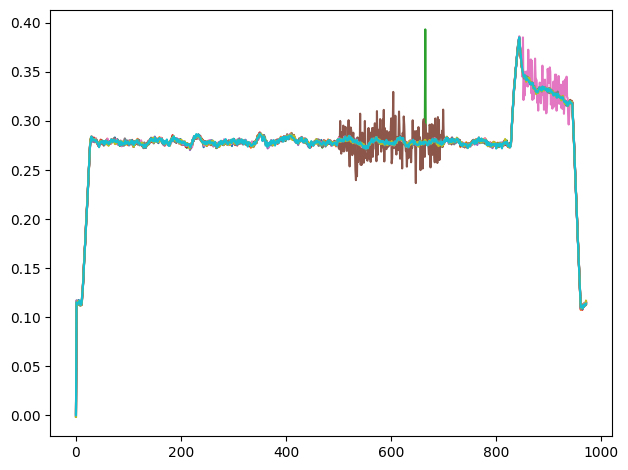

In [26]:
sampled_features = features.sample(10, random_state=0)
for _, row in sampled_features.iterrows():
    plt.plot(row)
plt.tight_layout()
plt.show()

10개 무작위 선정해서 plot

전체적인 파형은 같지만 여러 유형의 이상 신호 존재

---

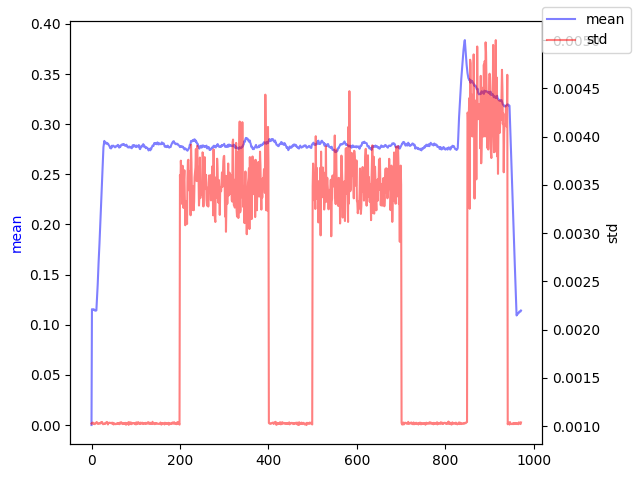

In [27]:
ax = features.mean(axis=0).plot(color='blue', alpha=0.5, label='mean')
ax.set_ylabel('mean', color='blue')
ax2 = ax.twinx()
features.std(axis=0).plot(ax=ax2, color='red', alpha=0.5, label='std')
ax2.set_ylabel('std')
ax.figure.legend()
plt.tight_layout()
plt.show()

axis=0 일때, features mean 그림

- 200 ~ 400, 500 ~ 700, 900 ~ 1,000 구간에서의 std 값이 유독 튐으로 해당 부분에서 이상 신호가 많이 발생하는 것으로 추정

- mean 값이 일정하지 않고 흔들리는 것으로 보아 noise or 적은 수의 이상 신호가 존재할 것으로 예상됨

---

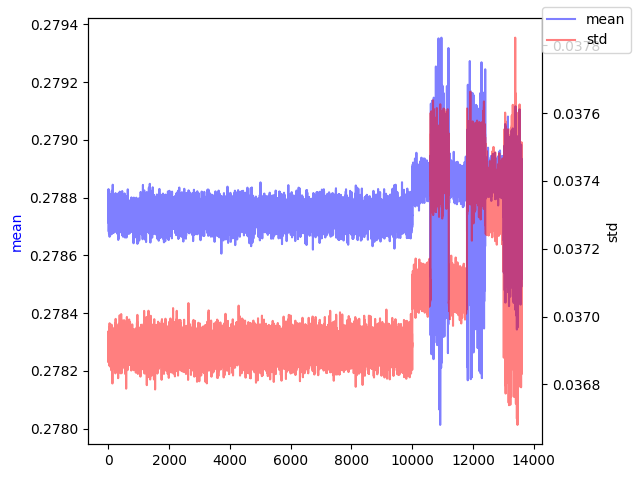

In [28]:
ax = features.mean(axis=1).plot(color='blue', alpha=0.5, label='mean')
ax.set_ylabel('mean', color='blue')
ax2 = ax.twinx()
features.std(axis=1).plot(ax=ax2, color='red', alpha=0.5, label='std')
ax2.set_ylabel('std')
ax.figure.legend()
plt.tight_layout()
plt.show()

axis=1 일때, features mean 그림

- mean, std 둘다 10,000 이후의 index에서 변화가 심함

- 이상 신호가 있다면 0 ~ 10,000 사이는 없거나 적을 확률이 높고 10,000 이상에서 발생할 확률이 높음

---
### target 탐색

In [29]:
print(df['target'].unique())

[0 1 4 2 5 3 6]


target (0, 1, 2, 3, 4, 5, 6) 별로 어떤 종류의 신호인지 5개씩 random sampling 해서 시각화

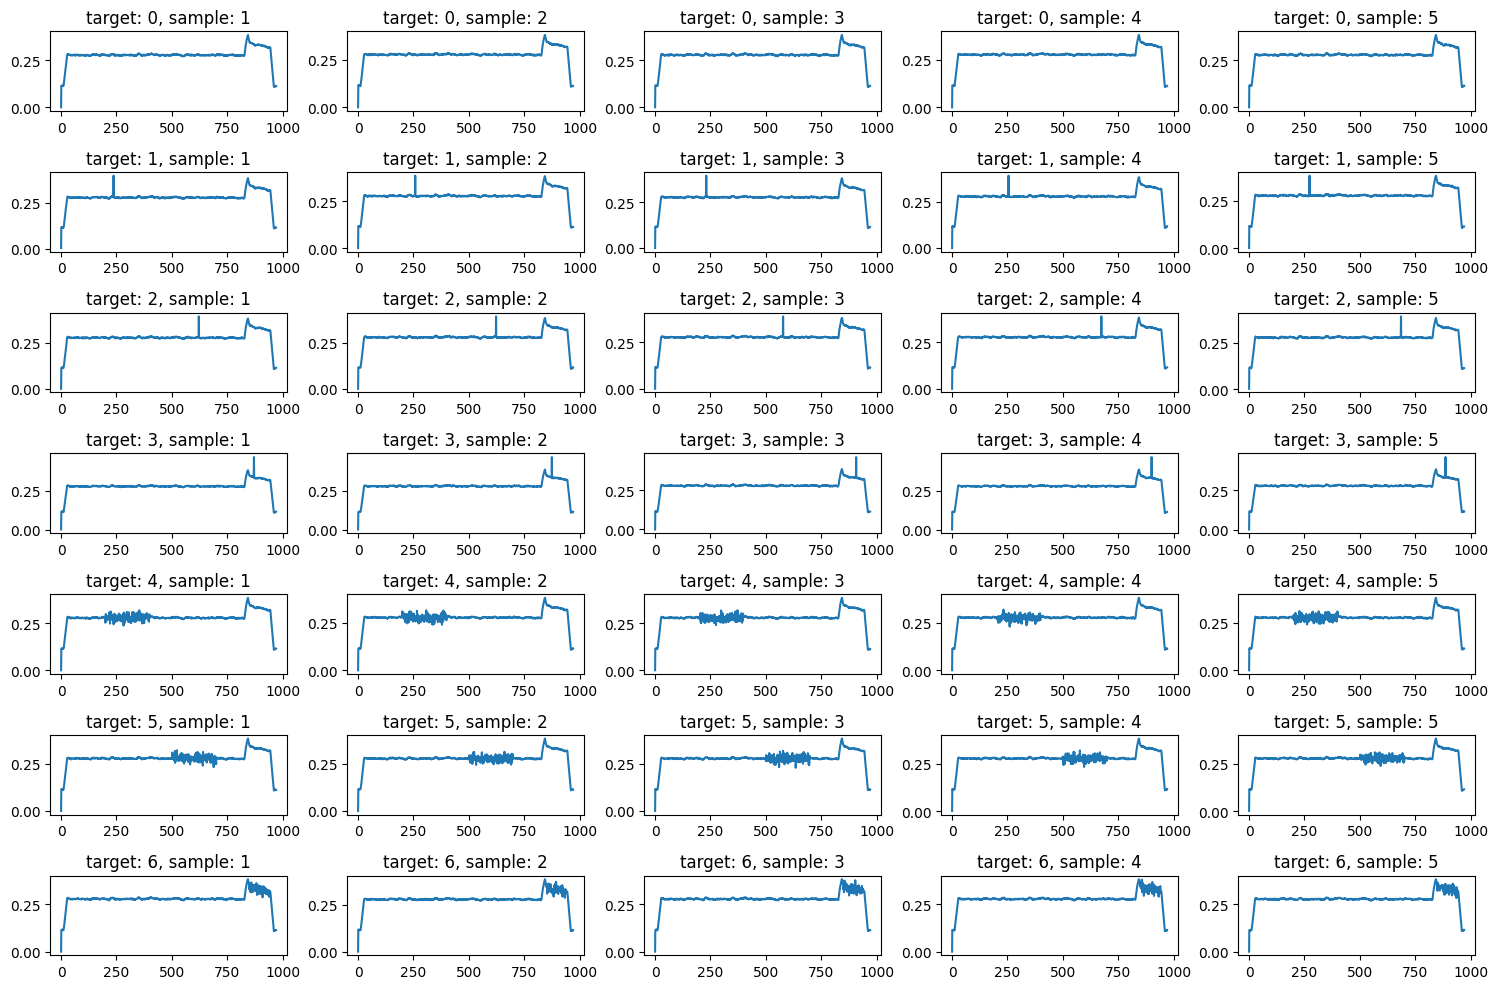

In [30]:
num_samples = 5
unique_targets = np.sort(df['target'].unique())
n_unique_targets = len(unique_targets)

fig, axes = plt.subplots(n_unique_targets, num_samples, figsize=(15, 10))
for idx, target in enumerate(unique_targets):
    df_sub = df[df['target'] == target].sample(num_samples, random_state=0)
    for j in range(num_samples):
        ax = axes[idx, j]
        ax.plot(df_sub.iloc[j, :-1].values)
        ax.set_title(f'target: {int(target)}, sample: {j+1}')
plt.tight_layout()
plt.show()

random sample 시각화 결과 target 별로 이상 신호가 다르고 발생 구간이 다름

※ 참고: 우리가 관심을 가지는 센서 데이터의 구간이 정해져 있음

| Target | 설명                                     | 구간     |
|--------|------------------------------------------|---------|
| 0      | 정상 신호                                 |         |
| 1      | 1 point 튄 이상 신호                      | 1번 구간 |
| 2      | 1 point 튄 이상 신호                      | 2번 구간 |
| 3      | 1 point 튄 이상 신호                      | 3번 구간 |
| 4      | 100 points 이상의 흔들리는 불안정 이상 신호 | 1번 구간 |
| 5      | 100 points 이상의 흔들리는 불안정 이상 신호 | 2번 구간 |
| 6      | 100 points 이상의 흔들리는 불안정 이상 신호 | 3번 구간 |

<br>

---

정상 신호와 이상 신호 간의 클래스 비율 확인하여 불균형 있는지 확인

0    10000
1      600
4      600
2      600
5      600
3      600
6      600
Name: target, dtype: int64


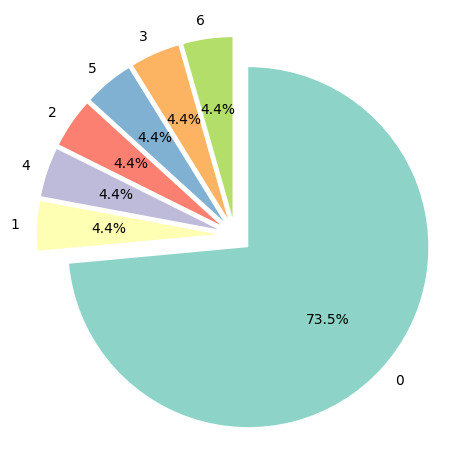

In [31]:
import matplotlib.cm as cm

target_value_counts = df['target'].value_counts()
print(target_value_counts)
plt.pie(target_value_counts, labels=target_value_counts.index, explode=([0.1]*len(target_value_counts)), autopct='%1.1f%%', colors=cm.Set3.colors, startangle=90, counterclock=False)
plt.tight_layout()
plt.show()

| Target | 설명                                     | 구간     | 개수   | 비율  |
|--------|------------------------------------------|---------|--------|-------|
| 0      | 정상 신호                                 |         | 10,000 | 73.5% |
| 1      | 1 point 튄 이상 신호                      | 1번 구간 | 600    | 4.4%  |
| 2      | 1 point 튄 이상 신호                      | 2번 구간 | 600    | 4.4%  |
| 3      | 1 point 튄 이상 신호                      | 3번 구간 | 600    | 4.4%  |
| 4      | 100 points 이상의 흔들리는 불안정 이상 신호 | 1번 구간 | 600    | 4.4%  |
| 5      | 100 points 이상의 흔들리는 불안정 이상 신호 | 2번 구간 | 600    | 4.4%  |
| 6      | 100 points 이상의 흔들리는 불안정 이상 신호 | 3번 구간 | 600    | 4.4%  |

정상 신호 대 이상 신호 비율 - 73.5% : 26.5%
- 정상 신호와 이상 신호 간 클래스 비율이 적절함

---
신호 한 개의 데이터에서 이상 신호 데이터 비율 확인 (비정상/정상)

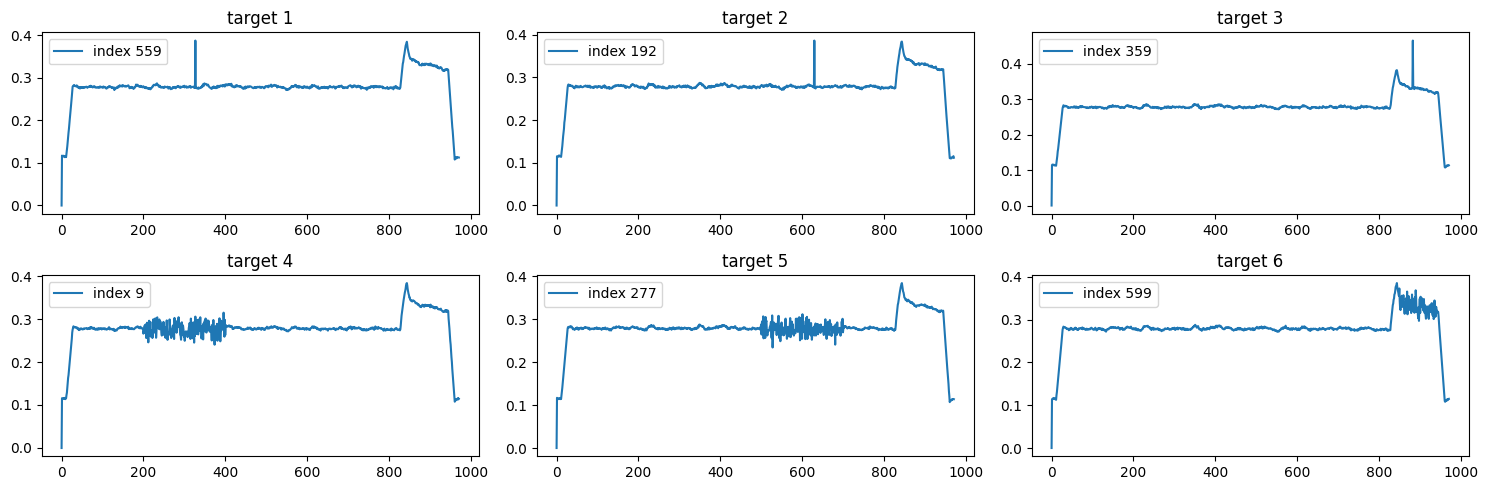

In [32]:
target_values = [1, 2, 3, 4, 5, 6]
n = 1

np.random.seed(0)
plt.figure(figsize=(15, 5))
for i, target_value in enumerate(target_values, start=1):
    target_df = df[df['target'] == target_value].iloc[:, :-1]
    random_indices = np.random.randint(0, min(len(target_df), 600), 1)
    target_indices = target_df.iloc[random_indices]

    plt.subplot(2, 3, i)
    for index, row in enumerate(target_indices.values):
        plt.plot(row, label=f'index {random_indices[index]}')
    plt.legend(loc='best')
    plt.title(f'target {target_value}')
plt.tight_layout()
plt.show()

target 별로 데이터 1개씩 sampling 해서 시각화 (plt.xlim() 이용해 확대해서 확인, 길어서 생략)
- target 1, 2, 3 구간: 이것만 봐서 모름, 중복해서 여러개 겹친 후 판단
- target 4 구간: 200 ~ 400 (200 points)
- target 5 구간: 500 ~ 700 (200 points)
- target 6 구간: 850 ~ 940 (90 points)

---

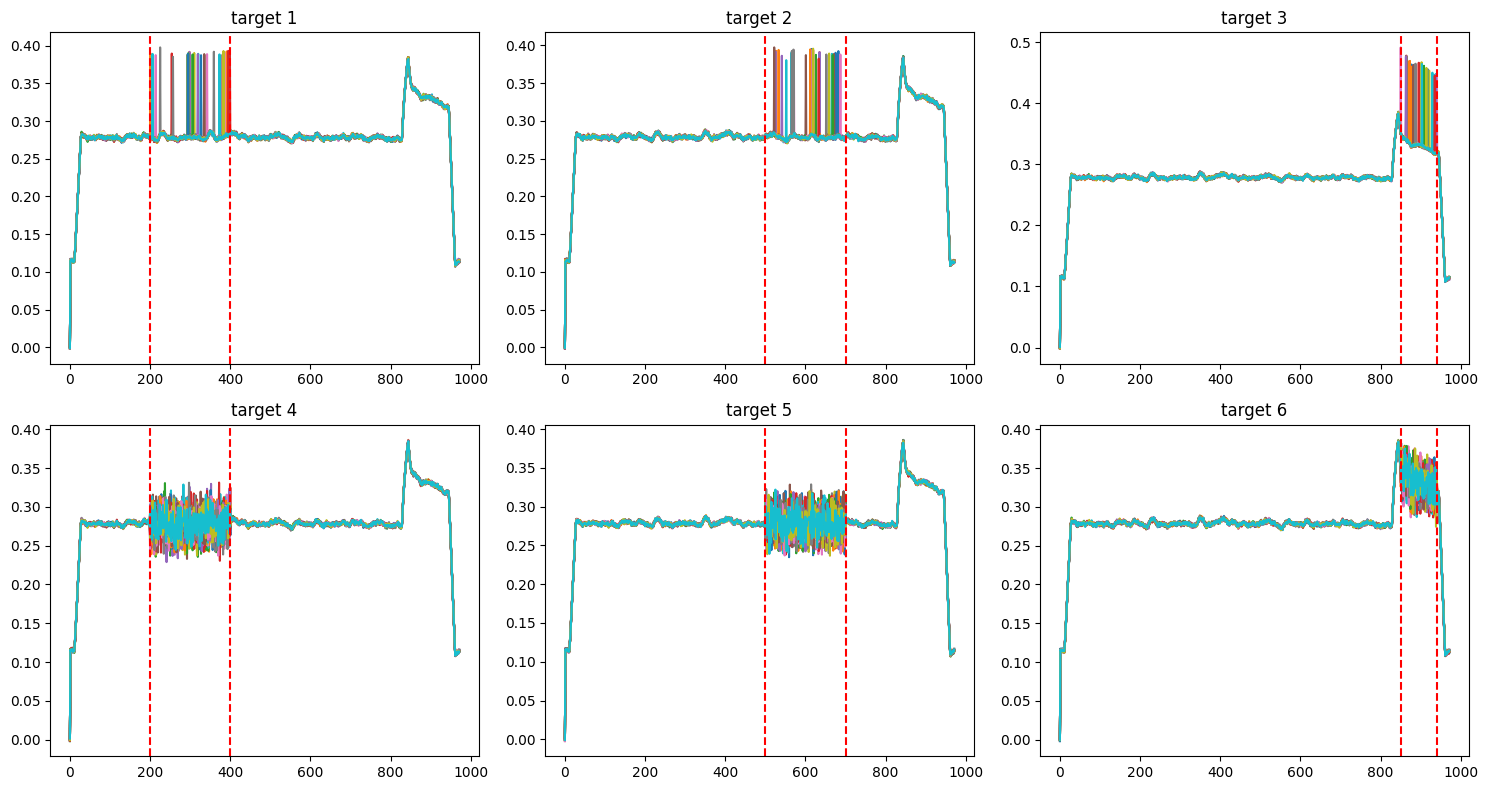

In [33]:
target_values = [1, 2, 3, 4, 5, 6]
n = 30

vertical_lines = {
    1: [200, 400],
    2: [500, 700],
    3: [850, 940],
    4: [200, 400],
    5: [500, 700],
    6: [850, 940]
}

np.random.seed(0)
plt.figure(figsize=(15, 8))
for i, target_value in enumerate(target_values, start=1):
    target_df = df[df['target'] == target_value].iloc[:, :-1]
    random_indices = np.random.randint(0, 600, n)
    target_indices = target_df.iloc[random_indices]

    plt.subplot(2, 3, i)
    for index, row in enumerate(target_indices.values):
        plt.plot(row)
    for line in vertical_lines[target_value]:
        plt.axvline(x=line, color='r', linestyle='--')
    plt.title(f'target {target_value}')
plt.tight_layout()
plt.show()

target 별로 데이터 30개씩 sampling 해서 시각화
- target 1 구간: 200 ~ 400 (1 points)
- target 2 구간: 500 ~ 700 (1 points)
- target 3 구간: 850 ~ 940 (1 points)
- target 4 구간: 200 ~ 400 (200 points)
- target 5 구간: 500 ~ 700 (200 points)
- target 6 구간: 850 ~ 940 (90 points)

---

위 시각화 결과를 통해 다음과 같은 패턴을 확인할 수 있었습니다.

| Target | 설명                                     | index   | 개수   | 비율  |
|--------|------------------------------------------|---------|--------|-------|
| 0      | 정상 신호                                 |         | 10,000 | 73.5% |
| 1      | 1 point 튄 이상 신호                      | 200~400 | 600    | 4.4%  |
| 2      | 1 point 튄 이상 신호                      | 500~700 | 600    | 4.4%  |
| 3      | 1 point 튄 이상 신호                      | 850~940 | 600    | 4.4%  |
| 4      | 200 points 흔들리는 불안정 이상 신호       | 200~400 | 600    | 4.4%  |
| 5      | 200 points 이상의 흔들리는 불안정 이상 신호 | 500~700 | 600    | 4.4%  |
| 6      | 90 points 이상의 흔들리는 불안정 이상 신호  | 850~940 | 600    | 4.4%  |

이 내용을 기반으로 Feature scaling 진행 후, 해당 데이터에 적합한 머신러닝 모델을 개발하겠습니다.

---
## **모델**

- 설명 불가능한 딥러닝 모델 보다는 설명할 수 있는 머신러닝 모델을 우선 고려
- target 데이터가 있기 때문에 분류해주는 머신러닝 모델 평가 (강사님이 다 돌려보래서 배운 분류 모델 전부 돌릴 예정)

---
### 머신러닝 모델 학습을 위한 Feature scaling

**Standardization** 선정

선정 근거
- Standardization
   1. 평균과 표준편차를 이용하기 떄문에, 이상 신호 값이 표준편차에 영향을 줄 정도로 많지 않는 이상 데이터 전체에 미치는 영향이 Normalization에 비해 상대적으로 적음

- Normalization
   1. 이상 신호 값이 엄청나게 크면 데이터가 전체적으로 한쪽으로 쏠림 → 따라서 정상 값들이 작은 구간 내로 몰릴 것으로 예상됨

---
### 모델 평가 계획
- 배운 내용 위주로 hyperparmeter를 설정 (데이터 값이 커서 속도가 매우 느림)
- 결과가 좋으면 (StratifiedKFold + GridSearchCV)를 이용해서 hyperparameter tuning
- 결과가 안 좋으면 hyperparameter 몇번 변경하고 값이 좋아지면 hyperparameter tuning
- 기본 학습 소요 시간이 10분 이상 되는 모델은 차원 축소 알고리즘(PCA or LDA) 적용

<br>

| No. | 머신러닝 모델           | 상세                                                                                  |
|-----|------------------------|---------------------------------------------------------------------------------------|
| 1   | KNN                    | target 7개라 n_neighbors=7로 학습                                                      |
| 2   | Logistic Regression    | 제약식 평가 (penalty = [l1, l2, elasticnet])                                           |
| 3   | Naive Bayes            |                                                                                       |
| 4   | Decision Tree          | max_depth 평가, criterion 평가 (gini, entropy)                                         |
| 5   | Support Vector Machine | kernel 평가, C 평가                                                                    |
| 6   | Random Forest          | max_depth 평가, criterion 평가 (gini, entropy)                                         |
| 7   | AdaBoost               |                                                                                       |
| 8   | GradientBoosting       | max_depth 평가, learning rate 평가                                                     |
| 9   | LDA                    |                                                                                       |
| 10  | Voting (앙상블)         | estimator 평가 (위 모델들 조합), voting 평가 (soft, hard)                              |
| 11  | Bagging (앙상블)        | estimator 평가 (위 모델들 조합), n_estimators 평가                                     |
| 12  | Stacking (앙상블)       | estimator, final estimator 평가 (위 모델들 조합)                                       |


---
분류 결과를 보기 위한 함수 작성
- accuracy: 전체 예측 중 올바른 예측의 비율
- precision: 모델이 양성이라고 예측한 것 중 실제로 양성인 것의 비율
- recall: 실제 양성 샘플 중 모델이 양성으로 올바르게 예측한 샘플의 비율
- f1 score: 정밀도와 재현율의 조화 평균 (f1 score가 낮으면 모델의 정밀도와 재현율이 모두 낮다)
- confusion matrix: 모델이 클래스를 어떻게 예측했는지
- calssification report: 각 클래스별로 정밀도, 재현율, F1 점수

In [34]:
def print_result_classifier(y, pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import confusion_matrix, classification_report
    accuracy = accuracy_score(y, pred)
    precision = precision_score(y, pred, average='macro', zero_division=0)
    recall = recall_score(y, pred, average='macro', zero_division=0)
    f1 = f1_score(y, pred, average='macro', zero_division=0)
    print(f'accuracy: {accuracy:.6f}, precision: {precision:.6f}, recall: {recall:.6f}, f1_score: {f1:.6f}')
    print(confusion_matrix(y, pred))
    print(classification_report(y, pred))

StratiFiedKFold + GridSearchCV 사용을 위한 함수 작성

In [35]:
def grid_search_cv(model_class, X_train, y_train, param_grid, n_splits=5):
    from sklearn.model_selection import StratifiedKFold, GridSearchCV
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    model = model_class(random_state=0)
    grid_cv = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy')
    grid_cv.fit(X_train, y_train)
    clf = grid_cv.best_estimator_
    grid_cv_results_df = pd.DataFrame(grid_cv.cv_results_).T
    return clf, grid_cv_results_df

In [36]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

---
## **`모델 평가`**

---
1. KNN
   - target이 7개 이므로 n_nighbors=7 넣고 학습

In [39]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print_result_classifier(y_test, pred)

accuracy: 0.768382, precision: 0.536558, recall: 0.295689, f1_score: 0.325831
[[1951    0    0    0    0    0    0]
 [ 109   26    0    0    0    0    0]
 [ 114    0   19    0    0    0    0]
 [  34    0    0   94    0    0    0]
 [ 121    0    0    0    0    0    0]
 [ 130    0    0    0    0    0    0]
 [ 122    0    0    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1951
           1       1.00      0.19      0.32       135
           2       1.00      0.14      0.25       133
           3       1.00      0.73      0.85       128
           4       0.00      0.00      0.00       121
           5       0.00      0.00      0.00       130
           6       0.00      0.00      0.00       122

    accuracy                           0.77      2720
   macro avg       0.54      0.30      0.33      2720
weighted avg       0.69      0.77      0.69      2720



c:\Users\rkdeo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rkdeo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rkdeo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

KNN 결론 **`(모델 후보 탈락)`**
- accuracy: 70% 넘는 확률로 괜찮아 보이지만 부분의 예측이 높은 비율을 차지하는 target 0(73.5%)에 편향됨
- precision: 예측한 것 중 절반 이상이 실제 양성으로 이것도 target 0에 편향
- recall: 실제 target 예측을 못한다고 볼 수 있으며, 특히 4, 5, 6 target을 구별하지 못함
- f1 score: precision, recall 모두 낮아 매우 비효율적인 모델
- confusion matrix: 대부분 예측이 target 0으로 되어 있어 모델이 다양한 클래스를 구별하는데 실패
- classification report: 클래스 예측을 못하며, class 4, 5, 6은 전부 예측 못함

---
2. Logistic Regression
   - 제약식 평가 (penalty = [l1, l2, elasticnet])
   > The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization with primal formulation, or no regularization. The ‘liblinear’ solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty. The Elastic-Net regularization is only supported by the ‘saga’ solver.

In [40]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear')
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print_result_classifier(y_test, pred)

accuracy: 0.797059, precision: 0.592917, recall: 0.395721, f1_score: 0.447357
[[1937    3    3    5    2    0    1]
 [  53   59    2    1   18    2    0]
 [  61    1   49    0    2   20    0]
 [  52    0    0   65    0    0   11]
 [  67   22    8    5   17    2    0]
 [  61    4   37    2    1   25    0]
 [  84    1    0   21    0    0   16]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1951
           1       0.66      0.44      0.52       135
           2       0.49      0.37      0.42       133
           3       0.66      0.51      0.57       128
           4       0.42      0.14      0.21       121
           5       0.51      0.19      0.28       130
           6       0.57      0.13      0.21       122

    accuracy                           0.80      2720
   macro avg       0.59      0.40      0.45      2720
weighted avg       0.76      0.80      0.76      2720



L1 제약식 + solver: liblinear 결과
- accuracy: 70% 넘는 확률로 괜찮아 보이지만 부분의 예측이 높은 비율을 차지하는 target 0(73.5%)에 편향됨
- precision: 예측한 것 중 절반 이상이 실제 양성으로 이것도 target 0에 편향
- recall: 실제 target 예측을 못한다고 볼 수 있으며, 특히 4, 5, 6 target을 거의 구별 못함
- f1 score: precision, recall 모두 낮아 매우 비효율적인 모델
- confusion matrix: 대부분 예측이 target 0으로 되어 있어 모델이 다양한 클래스를 구별하는데 실패
- classification report: 클래스 예측을 못하며, class 4, 5, 6은 대부분 예측 못함

In [41]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2')
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print_result_classifier(y_test, pred)

accuracy: 0.773162, precision: 0.454791, recall: 0.419122, f1_score: 0.425819
[[1845   29   33   15   14   10    5]
 [  38   63    8    4   17    4    1]
 [  35    4   59    6    4   22    3]
 [  40    7    1   66    2    1   11]
 [  26   24   18   11   24   14    4]
 [  22   16   38   10   10   26    8]
 [  55    9    7   21    4    6   20]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1951
           1       0.41      0.47      0.44       135
           2       0.36      0.44      0.40       133
           3       0.50      0.52      0.51       128
           4       0.32      0.20      0.24       121
           5       0.31      0.20      0.24       130
           6       0.38      0.16      0.23       122

    accuracy                           0.77      2720
   macro avg       0.45      0.42      0.43      2720
weighted avg       0.75      0.77      0.76      2720



c:\Users\rkdeo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


L2 제약식
- accuracy: 70% 넘는 확률로 괜찮아 보이지만 부분의 예측이 높은 비율을 차지하는 target 0(73.5%)에 편향됨
- precision: target 0에 편향되있지만, 기존과는 달리 target 0도 구별 못함
- recall: 실제 target 예측을 못한다고 볼 수 있으며, 특히 4, 5, 6 target을 거의 구별 못함
- f1 score: precision, recall 모두 낮아 매우 비효율적인 모델
- confusion matrix: 대부분 예측이 target 0으로 되어 있어 모델이 다양한 클래스를 구별하는데 실패
- classification report: 클래스 예측을 못하며, class 4, 5, 6은 대부분 예측 못함

In [42]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.01)
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print_result_classifier(y_test, pred)

accuracy: 0.811397, precision: 0.582217, recall: 0.459322, f1_score: 0.504929
[[1918    3    5    2   11    8    4]
 [  41   68    4    0   18    3    1]
 [  45    1   60    0    3   22    2]
 [  42    1    0   74    0    1   10]
 [  41   22    7    2   33    9    7]
 [  41    2   36    1    8   32   10]
 [  72    2    0   22    2    2   22]]
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1951
           1       0.69      0.50      0.58       135
           2       0.54      0.45      0.49       133
           3       0.73      0.58      0.65       128
           4       0.44      0.27      0.34       121
           5       0.42      0.25      0.31       130
           6       0.39      0.18      0.25       122

    accuracy                           0.81      2720
   macro avg       0.58      0.46      0.50      2720
weighted avg       0.78      0.81      0.79      2720



c:\Users\rkdeo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Elasticnet + solver: saga + l1_ratio: 0.01
- accuracy: 70% 넘는 확률로 괜찮아 보이지만 부분의 예측이 높은 비율을 차지하는 target 0(73.5%)에 편향됨
- precision: 예측한 것 중 절반 이상이 실제 양성으로 이것도 target 0에 편향
- recall: 실제 target 예측을 못한다고 볼 수 있으며, 특히 4, 5, 6 target을 거의 구별 못함
- f1 score: precision, recall 모두 낮아 매우 비효율적인 모델
- confusion matrix: 대부분 예측이 target 0으로 되어 있어 모델이 다양한 클래스를 구별하는데 실패
- classification report: 클래스 예측을 못하며, class 4, 5, 6은 대부분 예측 못함

Logistic Regression 결론 **`(모델 후보 탈락)`**
- L1, L2, Elastinet 성능이 전부 좋지 않음
- Elastinet > L1 > L2 성능 순
- KNN 모델보다 조금 더 나은 수준
- class 4, 5, 6를 제대로 예측하지 못한 이유 (추정)
  - class 1, 2, 3은 outlier로 회귀식에 영향을 주지만, 4, 5, 6은 평균 0, 분산이 큰 random noise 형태로 회귀식에 매우 적응 영향을 줬을 것 같음
- 결과 값이 좋지 않아 hyperparameter tuning pass

---
3. Naive Bayes

In [43]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print_result_classifier(y_test, pred)

accuracy: 0.951103, precision: 0.886129, recall: 0.855564, f1_score: 0.847875
[[1951    0    0    0    0    0    0]
 [   0   91    0    0   44    0    0]
 [   0    0   97    0    0   36    0]
 [   0    0    0   76    0    0   52]
 [   0    0    0    0  121    0    0]
 [   0    0    0    0    0  130    0]
 [   0    0    0    1    0    0  121]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1951
           1       1.00      0.67      0.81       135
           2       1.00      0.73      0.84       133
           3       0.99      0.59      0.74       128
           4       0.73      1.00      0.85       121
           5       0.78      1.00      0.88       130
           6       0.70      0.99      0.82       122

    accuracy                           0.95      2720
   macro avg       0.89      0.86      0.85      2720
weighted avg       0.96      0.95      0.95      2720



Naive Bayes 결론 **`(모델 후보 선정)`**
- accuracy: 90%가 넘으며 상당히 높은 예측 정확도를 가짐
- precision: class 0, 1, 2 완벽하고 class 4, 5, 6이 상대적으로 낮음
- recall: class 0, 4, 5 정확하게 예측, class 1, 2, 3 예측이 안 좋음
- f1 score: class 3이 유독 낮은데 recall이 많이 낮음
- confusion matrix: class 0, 4, 5 정확히 예측, class 3은 58개가 6으로 예측, class 6은 9개가 3으로 예측
- classification report: class 0, 4, 5 예측은 매우 잘했지만, class 3, 6은 개선 필요
- 기존까지 진행했던 알고리즘 대비 빠른 속도를 가졌고 대비 예측이 정확한 편
- class 3과 class 6을 정확하게 구별할 수 있어야 함

---
4. Decision Tree
   - max_depth 평가, criterion 평가 (gini, entropy)

In [44]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

- 결과가 매우 좋음
- StratifiedKFold + GridSearchCV 사용해서 hyperparameter tuning 진행

In [45]:
# from sklearn.tree import DecisionTreeClassifier

# param_grid = {
#     'max_depth': [5, 10, 50, 100],
#     'criterion': ['gini', 'entropy']
# }

# clf, cv_result = grid_search_cv(DecisionTreeClassifier, X_train_scaled, y_train, param_grid)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)
# cv_result

Decision Tree 결론 **`(모델 후보 선정)`**
- StratifiedKFold, GridSearchCV를 이용한 결과가 더 안 좋음 (위의 기본 hyperparameter 결과로 분석)
- accuracy: 90%가 넘으며 정확도가 매우 높음
- precision: 가장 낮은게 class 2이며 90%에 육박
- recall: class 3 정확하게 예측, class 1, 2가 상대적으로 낮지만 매우 정확한편
- f1 score: 정확도와 정밀도가 조화를 잘 이루고 있음
- confusion matrix: 정말 소수의 오분류만 있어 매우 잘 예측
- classification report: 종합적으로 우수한 성능
- class 1, 2, 3 정도에서 낮은 recall 값을 보완해주면 좋을 듯
- 의사 결정 나무의 오버 피팅 가능성도 염두

---
5. Support Vector Machine
   - kernel 평가, C 평가

In [46]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print_result_classifier(y_test, pred)

accuracy: 0.983824, precision: 0.953960, recall: 0.951273, f1_score: 0.951311
[[1951    0    0    0    0    0    0]
 [   0  126    0    0    0    0    9]
 [   0    0  125    0    0    0    8]
 [   0    0    0  111    3    0   14]
 [   0    0    0    0  121    0    0]
 [   0    0    0    0    1  129    0]
 [   0    0    0    9    0    0  113]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1951
           1       1.00      0.93      0.97       135
           2       1.00      0.94      0.97       133
           3       0.93      0.87      0.90       128
           4       0.97      1.00      0.98       121
           5       1.00      0.99      1.00       130
           6       0.78      0.93      0.85       122

    accuracy                           0.98      2720
   macro avg       0.95      0.95      0.95      2720
weighted avg       0.99      0.98      0.98      2720



- 결과가 매우 좋음
- StratifiedKFold + GridSearchCV 사용해서 hyperparameter tuning 진행

In [47]:
# from sklearn.svm import SVC

# param_grid = {
#     'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
#     'C': [0.1, 1, 10]
# }

# clf, cv_result = grid_search_cv(SVC, X_train_scaled, y_train, param_grid)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)
# cv_result

Support Vector Machine 결론 **`(모델 후보 선정)`**
- StratifiedKFold, GridSearchCV를 이용한 결과 → C: 10, kernel: rbf 에서 최적
- accuracy: 90%가 넘으며 정확도가 매우 높음
- precision: class 3, 6을 제외한 나머지 100% 달성
- recall: class 6은 0.8대 이며 나머지는 매우 준수함
- f1 score: class 6만 낮고 매우 준수
- confusion matrix: class 1, 2, 3이 6으로 잘못 분리, class 6은 3으로 잘못 분리
- classification report: 종합적으로 우수한 성능
- class 3, 6은 신호의 기울기가 있는 구간으로 해당 구간 예측이 어려워 보임

---
6. Random Forest
   - max_depth 평가, criterion 평가 (gini, entropy)

In [48]:
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

In [49]:
# from sklearn.ensemble import RandomForestClassifier

# param_grid = {
#     'max_depth': [5, 10, 50, 100],
#     'criterion': ['gini', 'entropy']
# }

# clf, cv_result = grid_search_cv(RandomForestClassifier, X_train_scaled, y_train, param_grid)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)
# cv_result

Random Forest 결론 **`(모델 후보 선정)`**
- StratifiedKFold, GridSearchCV를 이용한 결과가 더 안 좋음 (위의 기본 hyperparameter 결과로 분석)
- accuracy: 90%가 넘으며 정확도가 매우 높음
- precision: 전부 높음, 다만 class 2, 3, 4의 경우 class 0으로 잘못 예측
- recall: class 1, 2의 경우 0.6~0.7이므로 개선 필요
- f1 score: class 1, 2 개선 필요
- confusion matrix: class 1, 2를 0으로 잘못 예측
- classification report: 종합적으로 우수한 성능이지만, class 1, 2 recall 개선 필요

---
7. AdaBoost

In [50]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=0)
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print_result_classifier(y_test, pred)

c:\Users\rkdeo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


accuracy: 0.762500, precision: 0.500206, recall: 0.287721, f1_score: 0.272859
[[1950    0    0    1    0    0    0]
 [ 135    0    0    0    0    0    0]
 [ 132    0    1    0    0    0    0]
 [ 125    0    0    3    0    0    0]
 [ 121    0    0    0    0    0    0]
 [ 130    0    0    0    0    0    0]
 [   2    0    0    0    0    0  120]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1951
           1       0.00      0.00      0.00       135
           2       1.00      0.01      0.01       133
           3       0.75      0.02      0.05       128
           4       0.00      0.00      0.00       121
           5       0.00      0.00      0.00       130
           6       1.00      0.98      0.99       122

    accuracy                           0.76      2720
   macro avg       0.50      0.29      0.27      2720
weighted avg       0.67      0.76      0.66      2720



c:\Users\rkdeo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rkdeo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rkdeo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

AdaBoost 결론 **`(모델 후보 탈락)`**
- accuracy: 70% 넘는 확률로 괜찮아 보이지만 부분의 예측이 높은 비율을 차지하는 target 0(73.5%)에 편향됨
- 해당 모델은 분석할 필요가 없을 정도로 매우 안 좋은 성능을 보임
- 다만 class 6의 경우 정확히 맞춤
- 잘 분류되지 않은 것에 대해 가중치가 적다가 마지막에 커진 것으로 보임

---
8. GradientBoosting
   - max_depth 평가, learning rate 평가
   - 해당 모형은 20분씩 걸리므로 차원 축소 방법을 적용해서 모델 학습

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
X_train_lda = lda.transform(X_train_scaled)
X_test_lda = lda.transform(X_test_scaled)

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(max_depth=2, learning_rate=0.1, random_state=0)
clf.fit(X_train_lda, y_train)
pred = clf.predict(X_test_lda)
print_result_classifier(y_test, pred)

accuracy: 0.911765, precision: 0.798589, recall: 0.747319, f1_score: 0.769636
[[1937    1    0    1    3    2    7]
 [  12   95    0    0   27    1    0]
 [  27    0   79    0    0   26    1]
 [   6    1    0  111    0    0   10]
 [  11   25    1    0   84    0    0]
 [  11    1   23    0    1   93    1]
 [  12    0    0   29    0    0   81]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1951
           1       0.77      0.70      0.74       135
           2       0.77      0.59      0.67       133
           3       0.79      0.87      0.83       128
           4       0.73      0.69      0.71       121
           5       0.76      0.72      0.74       130
           6       0.81      0.66      0.73       122

    accuracy                           0.91      2720
   macro avg       0.80      0.75      0.77      2720
weighted avg       0.91      0.91      0.91      2720



- accuracy: 정확도가 높음
- precision: class 0 제외, 70% 언저리로 학습 잘된 다른 모델에 비해 상대적으로 아쉬움
- recall: class 0 제외, 전체적으로 아쉬움
- f1 score: class 0 제외, 전체적으로 아쉬움
- confusion matrix: 오분류 하는 비율이 높은 편
- classification report: 종합적으로 무난한 성능으로 보임

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X_train_scaled, y_train)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(max_depth=2, learning_rate=0.1, random_state=0)
clf.fit(X_train_pca, y_train)
pred = clf.predict(X_test_pca)
print_result_classifier(y_test, pred)

accuracy: 0.849265, precision: 0.614594, recall: 0.534610, f1_score: 0.533162
[[1951    0    0    0    0    0    0]
 [   6  120    8    0    1    0    0]
 [   4    5  114    2    0    2    6]
 [ 126    0    0    0    0    0    2]
 [   0   51    9    0   58    3    0]
 [   1    4   59    0    2   64    0]
 [ 118    0    0    1    0    0    3]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1951
           1       0.67      0.89      0.76       135
           2       0.60      0.86      0.71       133
           3       0.00      0.00      0.00       128
           4       0.95      0.48      0.64       121
           5       0.93      0.49      0.64       130
           6       0.27      0.02      0.05       122

    accuracy                           0.85      2720
   macro avg       0.61      0.53      0.53      2720
weighted avg       0.80      0.85      0.81      2720



- class 3, 6의 경우 완전 예측 실패
- PCA의 n_components를 100까지 늘려도 16%만 설명 가능
- PCA 차원 축소는 후보 탈락

GradientBoosting 결론 **`(모델 후보 탈락)`**
- LDA 차원 축소 결고가 PCA 차원 축소결과보다 좋음
- RandomForest나 SupportVetorMachine처럼 좋은 결과는 아니지만, 50%는 넘어 앙상블 학습기에 적용할 수 있음
- 그러나 속도가 너무 느려 차원 축소법을 적용한 데이터라 앙상블 학습시, 데이터 shape이 달라 적용하기 어려움

---
9. LDA

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print_result_classifier(y_test, pred)

accuracy: 0.837868, precision: 0.727112, recall: 0.505953, f1_score: 0.562828
[[1950    0    0    0    0    0    1]
 [  36   80    0    0   19    0    0]
 [  52    0   58    0    0   23    0]
 [  25    0    0  101    0    0    2]
 [  62   24    0    0   35    0    0]
 [  61    0   37    0    0   31    1]
 [  67    0    0   31    0    0   24]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1951
           1       0.77      0.59      0.67       135
           2       0.61      0.44      0.51       133
           3       0.77      0.79      0.78       128
           4       0.65      0.29      0.40       121
           5       0.57      0.24      0.34       130
           6       0.86      0.20      0.32       122

    accuracy                           0.84      2720
   macro avg       0.73      0.51      0.56      2720
weighted avg       0.82      0.84      0.81      2720



LDA 결론 **`(모델 후보 탈락)`**
- accuracy: 정확도가 높은 편
- precision: class 0을 제외하면, 특히 class 6은 44%로 상당히 낮음
- recall: class 0을 제외하고 전체적으로 매우 낮고 class 6 12%
- f1 score: class 0을 제외하고 전체적으로 매우 낮고 class 6 12%
- confusion matrix: class 0을 제외하면 잘못된 예측 비율이 매우 높음
- classification report: 종합적으로 안 좋은 성능

---
### 단독 모델 평가 결과 **`Support Vector Machine`** 성능이 제일 좋음

### 추가 앙상블 학습(voting, bagging, stacking)에 선정된 모델
- Naive Bayes: class 0 매우 높은 성능, class 1, 2 상대적 떨어짐
- Decision Tree: class 1, 2, 5 매우 높은 성능, class 0 상대적 떨어짐
- SVC: 전체적으로 뛰어난 성능
- Random Forest: class 5, 6 매우 높은 성능, class 1, 2 상대적 떨어짐
- Gradient Boosting: 위 4개에 비해 오분류가 높은 편 (class 6 상대적 떨어짐)

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier

---
10. Voting
   - estimator 평가 (위 모델들 조합), voting 평가 (soft, hard)

**`Voting 평가`**
1. 매우 높은 성능을 보인 SVC, DecisionTree, RandomForest 사용해서 평가
2. 4개 모델 전부 돌려서 평가
3. voting soft, hard 바꿔가며 평가

In [55]:
# clf = VotingClassifier(
#     estimators=[
#         ('rf', RandomForestClassifier(random_state=0)),
#         ('svc', SVC(kernel='rbf', C=10)),
#         ('dt', DecisionTreeClassifier(random_state=0))
#     ],
#     voting='hard',
# )
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

In [56]:
# clf = VotingClassifier(
#     estimators=[
#         ('rf', RandomForestClassifier(random_state=0)),
#         ('svc', SVC(probability=True, kernel='rbf', C=10)),
#         ('dt', DecisionTreeClassifier(random_state=0))
#     ],
#     voting='soft',
# )
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

In [57]:
# clf = VotingClassifier(
#     estimators=[
#         ('rf', RandomForestClassifier(random_state=0)),
#         ('svc', SVC(kernel='rbf', C=10)),
#         ('dt', DecisionTreeClassifier(random_state=0)),
#         ('gnb', GaussianNB())
#     ],
#     voting='hard',
# )
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

In [58]:
# clf = VotingClassifier(
#     estimators=[
#         ('rf', RandomForestClassifier(random_state=0)),
#         ('svc', SVC(probability=True, kernel='rbf', C=10)),
#         ('dt', DecisionTreeClassifier(random_state=0)),
#         ('gnb', GaussianNB())
#     ],
#     voting='soft',
# )
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

Voting 결론 `(좋은 모델)`
- voting hard와 voting soft에는 미미한 차이 존재하며, soft 옵션이 몇개 차이로 더 나음
   - soft 옵션은 각 분류기의 예측 확률 평균으로 확률 정보를 활용한게 좋은 결과를 뽑아냈으리라 예측
- 가장 좋은 결과인 Voting - RandomForest + SVC + DecisionTree + GaussianNB 조합과 SVC 단일 모델과 비교시 (아래 흰색 테두리)
   - class 1, 2에 대한 예측은 안 좋아졌음
   - class 4에 대한 예측이 좋아졌고, class 6에 대한 예측을 완벽히 맞춤
- 어떤 class 에 비중을 두냐에 따라 SVC or Voting 모델은 사용하면 될듯

<img src="./image/model_result/5.%20Support%20Vector%20Machine_kfold_gridsearch.PNG" style="border: 2px solid white;">

---
11. Bagging
   - estimator 평가 (위 모델들 조합), n_estimators 평가

**`Bagging 평가`**
1. 4개 모델 전부 돌려서 평가
2. n_estimators 변경하며 평가
   - RandomForest의 경우 3시간을 넘어도 학습이 안되서 n_estimators=10만 평가 (+ DecisionTree)

In [59]:
# clf = BaggingClassifier(estimator=GaussianNB(),
#                         n_estimators=10,
#                         random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

In [60]:
# clf = BaggingClassifier(estimator=GaussianNB(),
#                         n_estimators=50,
#                         random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

In [61]:
# clf = BaggingClassifier(estimator=GaussianNB(),
#                         n_estimators=100,
#                         random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

기존 GaussianNB 모델과 큰 차이 없음 (아래 참고)

<img src="./image/model_result/3. NaiveBayse.PNG" style="border: 2px solid white;">

In [62]:
# clf = BaggingClassifier(estimator=RandomForestClassifier(random_state=0),
#                         n_estimators=10,
#                         random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

기존 RandomForest 모델보다 안좋아짐 (아래 참고)

<img src="./image/model_result/6. Random Forest.PNG" style="border: 2px solid white;">

In [63]:
# clf = BaggingClassifier(estimator=SVC(kernel='rbf', C=10),
#                         n_estimators=10,
#                         random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

In [64]:
# clf = BaggingClassifier(estimator=SVC(kernel='rbf', C=10),
#                         n_estimators=50,
#                         random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

In [65]:
# clf = BaggingClassifier(estimator=SVC(kernel='rbf', C=10),
#                         n_estimators=100,
#                         random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

기존 SVC 모델보다 안좋아짐 (아래 참고)

<img src="./image/model_result/5. Support Vector Machine_kfold_gridsearch.PNG" style="border: 2px solid white;">

In [66]:
# clf = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=0),
#                         n_estimators=10,
#                         random_state=0)
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

기존 DecisionTree 모델보다 안좋아짐 (아래 참고)

RandomForest지만 한 번 해보니 RandomForest 보다 좋은 결과

<img src="./image/model_result/4. Decision Tree.PNG" style="border: 2px solid white;">

Bagging 결론 **`(단일 모델보다 안 좋아짐)`**
- target 0에 데이터가 몰려있어 클래스 불균형으로 인한 개별 분류기의 편향이 원인으로 예상
- 또한 데이터가 무거워 hyperparameter 최적화가 어려움

---
12. Stacking
   - estimator, final estimator 평가 (위 모델들 조합)

**`Stacking 평가`**
1. base learner: RandomForest, DecisionTree, meta learner: SVC 평가
   - SVC 성능이 전반적으로 제일 좋아 meta learner 사용하고 그 다음 좋은 것을 base_learner로 입력

In [67]:
# clf = StackingClassifier(
#     estimators=[
#         ('rf', RandomForestClassifier(random_state=0)),
#         ('dt', DecisionTreeClassifier(random_state=0)),
#     ],
#     final_estimator=SVC(kernel='rbf', C=10))
# clf.fit(X_train_scaled, y_train)
# pred = clf.predict(X_test_scaled)
# print_result_classifier(y_test, pred)

In [68]:
clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=0)),
        ('dt', DecisionTreeClassifier(random_state=0)),
        ('gnb', GaussianNB())
    ],
    final_estimator=SVC(kernel='rbf', C=10))
clf.fit(X_train_scaled, y_train)
pred = clf.predict(X_test_scaled)
print_result_classifier(y_test, pred)

accuracy: 1.000000, precision: 1.000000, recall: 1.000000, f1_score: 1.000000
[[1951    0    0    0    0    0    0]
 [   0  135    0    0    0    0    0]
 [   0    0  133    0    0    0    0]
 [   0    0    0  128    0    0    0]
 [   0    0    0    0  121    0    0]
 [   0    0    0    0    0  130    0]
 [   0    0    0    0    0    0  122]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1951
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00       133
           3       1.00      1.00      1.00       128
           4       1.00      1.00      1.00       121
           5       1.00      1.00      1.00       130
           6       1.00      1.00      1.00       122

    accuracy                           1.00      2720
   macro avg       1.00      1.00      1.00      2720
weighted avg       1.00      1.00      1.00      2720



Stacking 결론 `(가장 우수한 모델)`
- 첫번째 모델은 class 3, 4, 5, 6을 완벽하게 예측
   - class 에 비중을 두냐에 따라 SVC or Stacking 모델은 사용하면 될듯
- 두번째 모델은 클래스를 완벽하게 예측
   - Gaussian Naive Bayes가 확률적 특성을 잘 포착한 것으로 보임
- Stacking classifier는 다양한 유형의 base estimators를 조합하는 것이 모델의 정확도를 크게 향상 시키는 것을 확인

---
## 신호 파일 1개에 대한 모델 개발 완료

### 가장 잘 학습 된 StackingClassifier 모델로 나머지 신호 파일을 동일하게 돌려볼 예정
- 시간 문제로 각 파일 분석 진행 어려움 (Stacking 학습에만 2시간 소요)
- 데이터 전처리 및 모델도 동일하게 사용할 예정이라 함수화 해서 진행

In [69]:
def process_stacking_model(file_path):
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.ensemble import StackingClassifier

    def report_null_rows(df):
        null_rows = df.isnull().sum(axis=1)
        rows_with_null = null_rows[null_rows != 0].index.tolist()
        print('제거할 행:', rows_with_null)
        return df.drop(index=rows_with_null)

    def remove_uniform_columns(df):
        columns_to_remove = [col for col in df.columns if df[col].nunique() == 1]
        print('제거된 열:', columns_to_remove)
        return df.drop(columns=columns_to_remove)

    def check_duplicate_columns(df):
        df_T = df.T.drop_duplicates().T
        columns_to_remove = df.columns.difference(df_T.columns)
        df_T['target'] = df_T['target'].astype(int)
        print('제거된 열:', columns_to_remove.tolist())
        return df_T

    def print_result_classifier(y, pred):
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        from sklearn.metrics import confusion_matrix, classification_report
        accuracy = accuracy_score(y, pred)
        precision = precision_score(y, pred, average='macro', zero_division=0)
        recall = recall_score(y, pred, average='macro', zero_division=0)
        f1 = f1_score(y, pred, average='macro', zero_division=0)
        print(f'accuracy: {accuracy:.6f}, precision: {precision:.6f}, recall: {recall:.6f}, f1_score: {f1:.6f}')
        print(confusion_matrix(y, pred))
        print(classification_report(y, pred))

    df = pd.read_pickle(file_path)
    df = report_null_rows(df)
    df = remove_uniform_columns(df)
    df = check_duplicate_columns(df)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=0)),
            ('dt', DecisionTreeClassifier(random_state=0)),
            ('gnb', GaussianNB())
        ],
        final_estimator=SVC(kernel='rbf', C=10))
    clf.fit(X_train_scaled, y_train)
    pred = clf.predict(X_test_scaled)
    print_result_classifier(y_test, pred)

def plot_random(file_path, n=10):
    import pandas as pd
    import matplotlib.pyplot as plt

    df = pd.read_pickle(file_path)
    features = df.iloc[:, :-1]
    sampled_features = features.sample(n, random_state=0)
    for _, row in sampled_features.iterrows():
        plt.plot(row)
    plt.tight_layout()
    plt.show()

---
파일 2

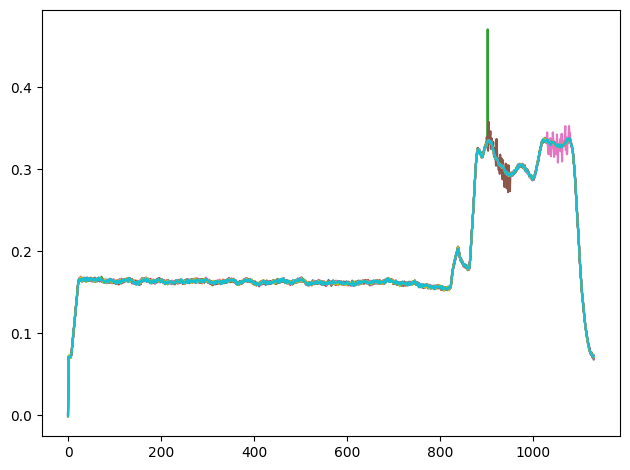

In [70]:
plot_random('./data/signal/data_2.pkl')

In [71]:
process_stacking_model('./data/signal/data_2.pkl')

제거할 행: []
제거된 열: []
제거된 열: []


---
파일 3

In [ ]:
plot_random('./data/signal/data_3.pkl')

In [ ]:
process_stacking_model('./data/signal/data_3.pkl')

---
파일 5

In [ ]:
plot_random('./data/signal/data_5.pkl')

In [ ]:
process_stacking_model('./data/signal/data_5.pkl')

- 파일 1에서 100% 정확히 예측한 Stacking 모델 사용 (기본 모델: RandomForest, DecisionTree, GaussianNB, 메타 모델: SVC)
- 다른 신호 파일에서도 100% 정확히 예측

---
## **결론**

### **처음 정의한 문제 해결**

- 본 프로젝트의 초기 단계에는 두 가지 주요 문제가 있었습니다. 첫 번째는 플라즈마 공정 중 발생하는 광 신호 데이터의 대량 처리 문제, 두 번째는 이를 통한 이상 신호의 조기 감지를 위한 진단 모델 개발 문제였습니다. 이를 해결하기 위해, 데이터 전처리 과정과 데이터 시각화를 통해, 데이터의 특성을 파악했습니다. 이후, 다양한 머신러닝 지도학습 모델 및 hyperparameter를 평가하여 각 모델의 이상 신호 진단 능력을 비교 분석했습니다.

- 평가 방법으로는 교차 검증과 함께 여러 성능 지표(accuracy, precision, recall, f1 score, confusion matrix, classification report)를 사용하여 모델의 성능을 종합적으로 평가하였습니다. 이러한 과정을 거쳐, 여러 모델 중에서 Stacking 모델이 가장 우수한 성능을 보임을 확인할 수 있었습니다. 이를 통해 다양한 유형의 플라즈마 광 신호 데이터 이상 신호를 보다 정확하고 효율적으로 감지할 수 있음을 입증하였습니다. 이러한 일련의 분석 과정을 통해 모델 선정 기준과 모델 성능의 구체적인 평가 방법에 대해 깊게 이해했습니다.


### **새로운 사실**

- 가장 많이 배운 것은 데이터 전처리, EDA(탐색적 데이터 분석), 데이터 시각화를 통해 불필요한 데이터를 어떻게 분석할지에 대한 고민하는 방법을 알게되었습니다. 또한, 앙상블 기법의 유용성을 알게되었는데, 여러 모델의 예측을 결합하는 앙상블 기법의 적용은 단일 모델을 사용할 때보다 훨씬 높은 정확도와 안정성을 달성하는 데 기여하였습니다. 특히 Stacking, Bagging, Boosting과 같은 다양한 앙상블 기법을 실험한 결과, 이들 기법이 모델의 오류를 감소시키고, 다양한 데이터 상황에 대한 모델의 일반화 능력을 향상시키는 데 유용함을 확인할 수 있었습니다.

- 그러나 데이터의 크기와 복잡성으로 인해 모델 학습에 상당한 시간과 자원이 소모될 수 있음을 인지하였습니다. 따라서 학습 주기를 자주 갖는 상황에서는 모델의 예측 정확도를 다소 희생하더라도, 상대적으로 학습 시간이 짧고 자원 소모가 적은 모델을 선택하는 것이 효율적일 수 있다는 점을 깨달았습니다. 이는 실제 운영 환경에서 모델을 배치하고 유지보수하는 데 있어 중요한 고려 사항이 될 것입니다. 향후 프로젝트에서 데이터 전처리와 모델 선택 전략을 더욱 세심하게 고려할 필요가 있음을 시사합니다. 또한 모델의 성능과 운영 효율성 사이에서 최적의 균형을 찾는 것이 중요함을 강조합니다.


### **기존 업무 효율화**

- 이 모델의 개발로 인해 플라즈마 공정 설비에서 이상 신호 진단의 업무 효율이 혁신적으로 개선될 것으로 기대됩니다. 이전 방식은 대량의 데이터를 수작업으로 분석하고 진단하는 데 많은 시간과 노력이 소요되었습니다. 하지만 이제 이 모델을 통해 데이터 분석과 이상 신호 진단이 자동화되어, 공정 설비에서 발생하는 이상 신호를 실시간으로 감지하고 즉각적으로 대응할 수 있게 되었습니다. 이로 인해, 공정 설비의 운영 중단 시간이 크게 감소하고, 문제를 조기에 발견하여 해결하는 능력이 향상될 것으로 기대됩니다.


### **데이터셋에 대한 인사이트**

- 플라즈마 광 신호 데이터셋을 분석함으로써, 특정 설비에서 자주 발생하는 이상 신호의 유형과 패턴에 대한 구체적인 이해를 얻을 수 있었습니다. 분석을 통해 우리는 설비의 정상 작동 시 발생하는 신호와 이상 상태에서 나타나는 신호 사이 차이를 명확히 식별할 수 있었으며, 특정 조건이나 시간대에 특정 이상 신호가 얼마나 자주 발생하는지 파악할 수 있었습니다.

- 이는 모델의 학습 과정에서 매우 중요하게 활용되었습니다. 이상 신호의 유형과 패턴을 정확하게 파악하고 분류하기 위한 다양한 모델 선정, hyperparameter 최적화는 물론 데이터 스케일링 방법 선정에 활용되었습니다. 이를 통해, 모델은 이상 신호의 미세한 변화에도 민감하게 반응하며, 이상 상태를 보다 신속하고 정확하게 식별할 수 있는 능력을 향상시키는 데 크게 기여하였습니다.


### **최종 결론**

- 프로젝트의 주요 목표는 플라즈마 공정 설비에서 발생 가능한 다양한 문제점들을 자동화하여 조기에 감지 및 진단하는 모델을 개발하는 것이었습니다. 이를 위해, 플라즈마 광 신호의 이상 신호를 실시간으로 측정하고 분석할 수 있는 센서 개발하여 데이터를 취득, 다양한 이상 신호를 효과적으로 분류하고 진단할 수 있는 머신러닝 모델을 설계 및 구현하였습니다.

- 이 과정에서 대표적인 머신러닝 지도학습 알고리즘 대부분을 활용하였으며, 최종적으로 성능 측면에서 가장 우수한 결과를 보인 Stacking 모델은 RandomForest, DecisionTree, GaussianNB를 기본 모델로, SVC를 메타 모델로 사용하여 정확히 예측했습니다.

- 이러한 접근 방식을 통해, 플라즈마 공정 중에 발생할 수 있는 공정 불안정성과 같은 문제를 신속하게 감지하고 분석할 수 있는 모델 개발 능력을 확보하였습니다. 개발된 머신러닝 모델으로 인적 자원 확보뿐만 아니라 이상 신호 조기 진단으로 인한 플라즈마 공정 안정성에 도움이 될 것으로 기대됩니다.